In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from config import API_KEY

# Load the dataset from the URL
url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"
ev_data = pd.read_csv(url)

# Inspect the dataset structure
ev_data.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,35.0,267929112,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,5.303509e+10
1,5YJ3E1EB1J,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,23.0,475911439,POINT (-122.6368884 47.7469547),PUGET SOUND ENERGY INC,5.303509e+10
2,WP0AD2A73G,Snohomish,Bothell,WA,98012.0,2016,PORSCHE,PANAMERA,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,15.0,0.0,1.0,101971278,POINT (-122.206146 47.839957),PUGET SOUND ENERGY INC,5.306105e+10
3,5YJ3E1EB5J,Kitsap,Bremerton,WA,98310.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,23.0,474363746,POINT (-122.6231895 47.5930874),PUGET SOUND ENERGY INC,5.303508e+10
4,1N4AZ1CP3K,King,Redmond,WA,98052.0,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150.0,0.0,45.0,476346482,POINT (-122.13158 47.67858),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10


In [4]:
# Your API key from AFDC
api_key = API_KEY

# Base URL for AFDC API
afdc_url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1.json?api_key={API_KEY}&fuel_type=ELEC&state=WA"

# Fetch charging station data for Washington
response = requests.get(afdc_url)
charging_stations = response.json()

# Convert the response to a DataFrame for analysis
charging_stations_df = pd.json_normalize(charging_stations['fuel_stations'], 
                                         sep='_', 
                                         record_path=None)

# Inspect relevant columns
charging_stations_df = charging_stations_df[['station_name', 'city', 'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_num']]
print(charging_stations_df.head())

                                        station_name      city  \
0                  City of Lacey - City Hall Parking     Lacey   
1  Seattle-Tacoma International Airport - General...   Seattle   
2                                        Avista Corp   Spokane   
3                                Steam Plant Parking   Spokane   
4                             BELLEVUE BELLEVUE CH 1  Bellevue   

   ev_level1_evse_num  ev_level2_evse_num  ev_dc_fast_num  
0                 NaN                 4.0             NaN  
1                 NaN                68.0             NaN  
2                 1.0                 2.0             NaN  
3                 NaN                 6.0             NaN  
4                 NaN                 2.0             NaN  


In [5]:
# Merge the datasets based on city
merged_data = pd.merge(ev_data, charging_stations_df, how='inner', left_on='City', right_on='city')

# Inspect the merged dataset
print(merged_data.head())

   VIN (1-10)  County     City State  Postal Code  Model Year   Make    Model  \
0  5YJ3E1EB1J  Kitsap  Poulsbo    WA      98370.0        2018  TESLA  MODEL 3   
1  5YJ3E1EB1J  Kitsap  Poulsbo    WA      98370.0        2018  TESLA  MODEL 3   
2  5YJ3E1EB1J  Kitsap  Poulsbo    WA      98370.0        2018  TESLA  MODEL 3   
3  5YJ3E1EB1J  Kitsap  Poulsbo    WA      98370.0        2018  TESLA  MODEL 3   
4  5YJ3E1EB1J  Kitsap  Poulsbo    WA      98370.0        2018  TESLA  MODEL 3   

            Electric Vehicle Type  \
0  Battery Electric Vehicle (BEV)   
1  Battery Electric Vehicle (BEV)   
2  Battery Electric Vehicle (BEV)   
3  Battery Electric Vehicle (BEV)   
4  Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  ...  \
0           Clean Alternative Fuel Vehicle Eligible  ...   
1           Clean Alternative Fuel Vehicle Eligible  ...   
2           Clean Alternative Fuel Vehicle Eligible  ...   
3           Clean Alternative Fuel Vehicle Eligibl

In [6]:
# Group by City to analyze the number of EVs and charging stations in each city
city_analysis = merged_data.groupby('City').agg({
    'VIN (1-10)': 'count',  # Assuming VIN column represents individual EVs
    'station_name': 'nunique',  # Counting unique charging stations
    'ev_level1_evse_num': 'sum',
    'ev_level2_evse_num': 'sum',
    'ev_dc_fast_num': 'sum'
}).rename(columns={'VIN (1-10)': 'EV_Count', 'station_name': 'Charging_Stations'})

# Calculate the ratio of EVs to charging stations
city_analysis['EVs_per_Station'] = city_analysis['EV_Count'] / city_analysis['Charging_Stations']

# Display the result
print(city_analysis.sort_values('EVs_per_Station', ascending=False).head())

           EV_Count  Charging_Stations  ev_level1_evse_num  \
City                                                         
Seattle    25356646                747                 0.0   
Bellevue    3020060                290                 0.0   
Vancouver    545675                 72             14950.0   
Redmond      304958                 41                 0.0   
Bothell      185679                 27                 0.0   

           ev_level2_evse_num  ev_dc_fast_num  EVs_per_Station  
City                                                            
Seattle            63780936.0       4265604.0     33944.639893  
Bellevue            6612890.0        239522.0     10414.000000  
Vancouver           1113775.0        470925.0      7578.819444  
Redmond             1041320.0        141322.0      7438.000000  
Bothell              391989.0        171925.0      6877.000000  


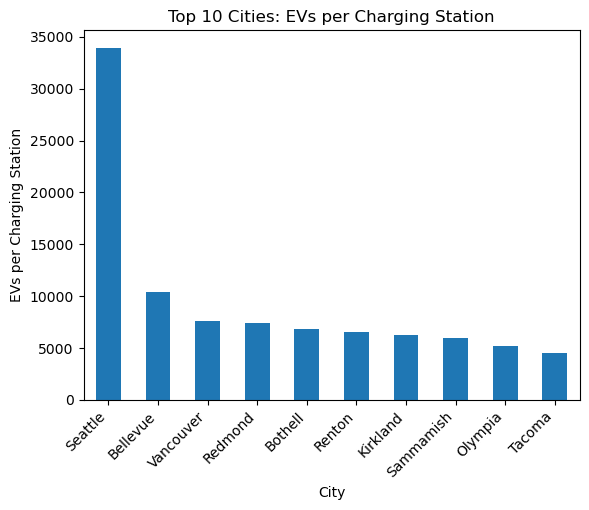

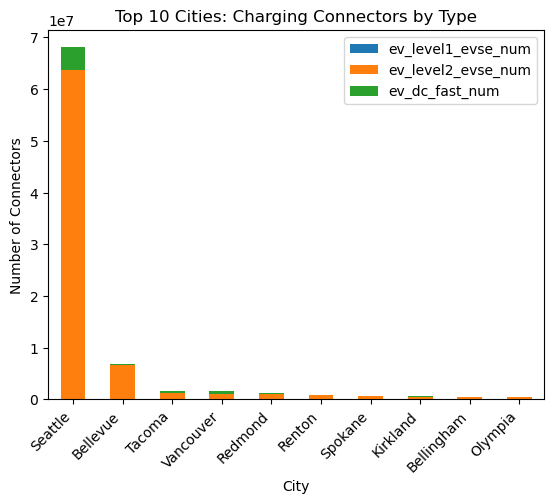

In [8]:
import matplotlib.pyplot as plt

# Plot the top 10 cities with the highest EVs per charging station
ax = city_analysis.nlargest(10, 'EVs_per_Station').plot(kind='bar', y='EVs_per_Station', legend=False)
plt.title('Top 10 Cities: EVs per Charging Station')
plt.xlabel('City')
plt.ylabel('EVs per Charging Station')

# Rotate the city labels on the x-axis to 45 degrees for better readability
plt.xticks(rotation=45, ha='right')  # Rotating the labels and aligning to the right
plt.show()

# Plot the total number of charging connectors by city
ax = city_analysis[['ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_num']].nlargest(10, 'ev_level2_evse_num').plot(kind='bar', stacked=True)
plt.title('Top 10 Cities: Charging Connectors by Type')
plt.xlabel('City')
plt.ylabel('Number of Connectors')

# Rotate the city labels on the x-axis to 45 degrees for better readability
plt.xticks(rotation=45, ha='right')  # Rotating the labels and aligning to the right
plt.show()

